In [13]:
from data import ImageDataModule, SeqVocab
from lit_trainer import LitBTTR

base_vocab = open('vocab_ids.txt', 'r').read().split('\n')
ids_dict = {line.strip().split('\t')[0]:line.strip().split('\t')[1] for line in open('ids_exp.txt', 'r').readlines()}


dm = ImageDataModule(
    data_dir='datasets/tkh-mth2k2/MTH1000',
    vocab=SeqVocab(base_vocab, ids_dict),  # Replace with your vocabulary
    batch_size=1,
    num_workers=1
)

model = LitBTTR.load_from_checkpoint(checkpoint_path='lightning_logs/gqivg4f4/checkpoints/epoch=68-step=2673-val_ExpRate=0.8427.ckpt',
    d_model=256, growth_rate=24, num_layers=16, nhead=8, num_decoder_layers=3, dim_feedforward=1024, dropout=0.3, beam_size=10, max_len=200, alpha=1.0, learning_rate=1.0, patience=20, vocab_size=len(dm.vocab), SOS_IDX=1, EOS_IDX=2, PAD_IDX=0)

model.eval()

LitBTTR(
  (bttr): BTTR(
    (encoder): Encoder(
      (model): DenseNet(
        (conv1): Conv2d(3, 48, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dense1): Sequential(
          (0): _Bottleneck(
            (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv1): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(96, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
          (1): _Bottleneck(
            (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv1): Conv2d(72, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): Bat

In [15]:
batch = next(iter(dm.val_dataloader()))
batch  = batch.to(device='cuda')
# model.forward()

In [4]:
batch.imgs[0].shape

torch.Size([3, 128, 128])

In [5]:
model.beam_search(batch.imgs[0])

[27, 28, 27, 6, 82, 7, 30, 67, 29, 387, 387, 387, 165]

In [6]:
vocab=SeqVocab(base_vocab, ids_dict)

In [ ]:
decoded_batch = []
for img in batch.imgs:
    decoded = model.beam_search(img)
    decoded_batch.append(decoded)

In [ ]:
# draw images
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

def draw_images(images, decoded, labels, font):
    # draw 10 images into a 2x5 grid
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    axs = axs.flatten()
    for i, (img, dec, label) in enumerate(zip(images, decoded, labels)):
        img = img.cpu().numpy().transpose(1, 2, 0)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        axs[i].imshow(img)
        axs[i].set_title(f"Decoded: {vocab.decode(dec)}, Label: {vocab.decode(label)}", fontsize=10, fontproperties=font)
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

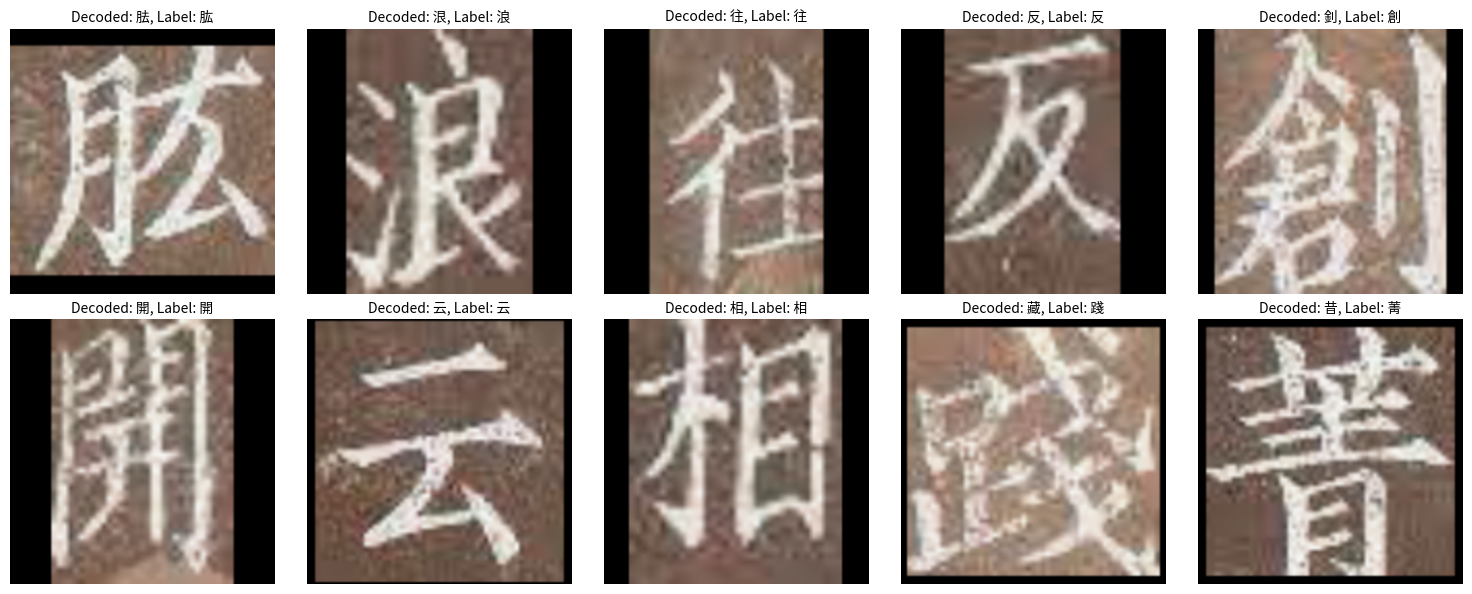

In [ ]:
import matplotlib.font_manager as fm
font_path = "assets/NotoSansCJKjp-Regular.otf" 
font = fm.FontProperties(fname=font_path)

draw_images(batch.imgs, decoded_batch, batch.indices, font)